In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
cifar10 = tfds.image.cifar.Cifar10()
cifar10.download_and_prepare()

In [2]:
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score
import random
# Some preprocessing code from https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/
def to_gen(ds, batch_size=50, n=None):
  Xs = []
  ys = []
  for x, y in ds.take(n):
    if len(Xs) >= batch_size:
      yield tf.stack(Xs, axis=0), tf.stack(ys, axis=0)
      Xs = []
      ys = []
    Xs.append(x)
    ys.append(y)
  yield tf.stack(Xs, axis=0), tf.stack(ys, axis=0)

def _to_categorical(datapoint):
  datapoint['label'] = tf.one_hot(datapoint['label'], 10)
  return datapoint

def _img_label_to_x_y(datapoint):
  x = tf.cast(datapoint['image'], dtype=tf.float32)/255.0
  y =  tf.cast(datapoint['label'], dtype=tf.float32)
  return x, y

def preprocess_test_images(datapoint):
  x = datapoint['image']
  x = tf.image.random_flip_left_right(x)
  x = tf.image.random_flip_up_down(x)
  x = tf.image.random_hue(x, 0.08)
  x = tf.image.random_saturation(x, 0.6, 1.6)
  x = tf.image.random_brightness(x, 0.05)
  x = tf.image.random_contrast(x, 0.7, 1.3)
  if random.random() > 0.5:
    x = tf.image.random_crop(x, (30, 30, 3))
    x = tf.image.resize(x, (32, 32,))
  datapoint['image'] = x
  return datapoint

def accuracy_for_model(model, ds, test_size=10000, batch_size=50):
  data = ds.take(test_size)
  y_test = []
  for x, y in data:
    y_test.append(y)
  y_pred = model.predict(to_gen(data, n=test_size, batch_size=batch_size))
  y_pred = np.argmax(y_pred, axis=1)
  y_test_max = np.argmax(np.array(y_test).squeeze(), axis=1)

  return accuracy_score(y_test_max, y_pred)


def run_cifar_10_benchmark(model_creator, train_n=200_000, batch_size=50):
  cifar10 = tfds.image.cifar.Cifar10()
  cifar10.download_and_prepare()
  dataset = cifar10.as_dataset()
  train = dataset['train']
  test  = dataset['test']

  train = train.repeat().shuffle(1000).map(_to_categorical).map(preprocess_test_images).map(_img_label_to_x_y)
  test = test.repeat().map(_to_categorical).map(_img_label_to_x_y)
  model = model_creator((32,32,3), 10)
  history = model.fit(to_gen(train, n=train_n, batch_size=batch_size))
  return accuracy_for_model(model, test, batch_size=batch_size)

In [3]:
import matplotlib.pyplot as plt

def image_gallery(imgs):
  # plot first few images
  for i, img in enumerate(imgs):
    # define subplot
    ax = plt.subplot(330 + 1 + i)
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(img)
  # show the figure
  plt.show()

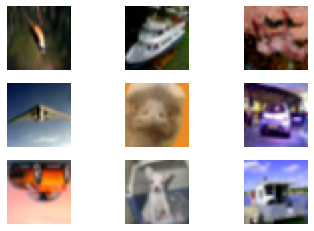

In [4]:
train = cifar10.as_dataset()['train'].repeat().shuffle(1000).map(_to_categorical).map(preprocess_test_images).map(_img_label_to_x_y)
imgs = [x for x, y in train.take(9)]
image_gallery(imgs)

In [5]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Flatten, Activation, Dense, MaxPooling2D, Dropout


def create_spatial_model(input_img_size, num_classes, num_residual_blocks=10):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Dropout(0.2))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.2))
  model.add(Dense(10, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [6]:
run_cifar_10_benchmark(create_spatial_model, batch_size=500)

400/400 [==============================] - 82s 206ms/step - loss: 2.1029 - accuracy: 0.2748


0.407

# Fourier

In [7]:
from tensorflow.keras.layers import Lambda

@tf.function
def fft_on_axis(x):
    x = tf.transpose(x, perm=[0, 3,  1, 2],)
    x_fft = tf.signal.rfft2d(x)
    result = tf.transpose(x_fft, perm=[0, 2, 3, 1])
    return result

@tf.function
def ifft_on_axis(x):
    x = tf.transpose(x, perm=[0, 3,  1, 2],)
    x_fft = tf.signal.irfft2d(x, IMG_SIZE)
    result = tf.transpose(x_fft, perm=[0, 2, 3, 1])
    return result

fft_layer = Lambda(fft_on_axis, name='fft2d')
ifft_layer = Lambda(ifft_on_axis, name='irfft2d')

@tf.function
def do_from_complex(x):
    real = tf.math.real(x)
    imag = tf.math.imag(x)
    zed = tf.stack([real, imag], axis=-1)
    return zed

@tf.function
def do_to_complex(x):
    real = x[..., 0]
    imag = x[..., 1]
    result = tf.complex(real, imag)
    return result

from_complex = Lambda(lambda x: do_from_complex(x), name='from_complex')
to_complex = Lambda(lambda x: do_to_complex(x), name='to_complex')

In [8]:
import numpy as np
import tensorflow.keras.regularizers as regularizers
import tensorflow.keras.initializers as initializers

class KernelFourierConvolution(tf.keras.layers.Layer):
  def __init__(self, filters, **kwargs):
    super(KernelFourierConvolution, self).__init__(**kwargs)
    self.filters = filters

  def add_kernel_weights(self, h, w):
    raise 'You must implement add_kernel_weights'

  def expand_kernel(self, h, w):
    raise 'Subclassing KernelFourierNetwork requires expand_kernel to be overridden'

  def compute_output_shape(self, input_shape):
    # channels last
    assert input_shape and len(input_shape) == 4
    assert input_shape[-1]
    output_shape = list(input_shape)
    output_shape[-1] = self.kernels*2
    return tuple(output_shape)

  def build(self, input_shape):
    h = input_shape[1]
    w = input_shape[2]
    self.h=h
    self.w=w
    self.add_kernel_weights(h, w)

  def call(self, inputs, training=False):
    # Update the kernel based on the new weights when training
    h = inputs.shape[1]
    w = inputs.shape[2]
    real_W, imag_W = self.expand_kernel(h, w)

    # Proceed like we did with the normal fourier conv layers
    real_input = inputs[..., 0]
    imag_input = inputs[..., 1]

    real_times_real = tf.einsum('ijkl,jko->ijko', real_input, real_W)
    imag_times_imag = tf.einsum('ijkl,jko->ijko', imag_input, imag_W)
    y_real = real_times_real-imag_times_imag

    real_times_imag = tf.einsum('ijkl,jko->ijko', real_input, real_W)
    imag_times_real = tf.einsum('ijkl,jko->ijko', imag_input, imag_W)
    y_imag = real_times_imag + imag_times_real
    return tf.stack([y_real, y_imag], axis=-1)

In [9]:
class LinearKernelFourierConvolution(KernelFourierConvolution):
  def __init__(self, filters, order=1, **kwargs):
    super(LinearKernelFourierConvolution, self).__init__(filters,**kwargs)
    self.order=order
    
  def add_kernel_weights(self, h, w):
    weights_shape = (2, self.filters, self.order+1)
    # One kernel set for row, one for column entry
    self.real_terms = self.add_weight(
        shape=weights_shape,
        initializer=initializers.RandomNormal(mean=0, stddev=0.005),
        trainable=True
    )

    # One kernel set for row, one for column entry
    self.imag_terms = self.add_weight(
        shape=weights_shape, 
        initializer=initializers.RandomNormal(mean=0, stddev=0.005),
        trainable=True
    )
  def expand_kernel(self, h, w):
    terms = self.real_terms
    row_terms = terms[0]
    col_terms = terms[1]
      
    cols = tf.range(h, dtype=tf.float32)/w - 0.5
    rows = tf.range(w, dtype=tf.float32)/w - 0.5

    res = []
    for filter in range(self.filters):
      coeffs_row = tf.unstack(row_terms[filter])
      coeffs_col = tf.unstack(col_terms[filter])

      r_res = tf.math.polyval(coeffs_row, rows)
      c_res = tf.math.polyval(coeffs_col, cols)
      r_res = tf.expand_dims(r_res, axis=0)
      c_res = tf.expand_dims(c_res, axis=1)
      r_res = tf.repeat(r_res, h, axis=0)
      c_res = tf.repeat(c_res, w, axis=1)
      res.append(r_res + c_res)
    real_kernel = tf.stack(res, axis=-1)

    terms = self.imag_terms
    row_terms = terms[0]
    col_terms = terms[1]
    res = []
    for filter in range(self.filters):
      coeffs_row = tf.unstack(row_terms[filter])
      coeffs_col = tf.unstack(col_terms[filter])

      r_res = tf.math.polyval(coeffs_row, rows)
      c_res = tf.math.polyval(coeffs_col, cols)
      r_res = tf.expand_dims(r_res, axis=0)
      c_res = tf.expand_dims(c_res, axis=1)
      r_res = tf.repeat(r_res, h, axis=0)
      c_res = tf.repeat(c_res, w, axis=1)
      res.append(r_res + c_res)
    imag_kernel = tf.stack(res, axis=-1)
    return real_kernel, imag_kernel

In [10]:
from tensorflow.keras.layers import Input, Dense, Flatten, Activation
from tensorflow.keras import Model

def linear_kernel_fourier_conv_residual_block(xi, order=1, filters=64):
  x = LinearKernelFourierConvolution(filters, order=order)(xi)
  x = Activation('relu')(x)
  return x + xi

def linear_kernel_fourier_conv_block(x, order=1, filters=64):
  x = LinearKernelFourierConvolution(filters, order=order)(x)
  x = Activation('relu')(x)
  return x

def create_linear_kernel_model(img_shape, num_classes, num_residual_blocks=10):
  order=1
  inputs = Input(shape=img_shape)
  x = fft_layer(inputs)
  x = from_complex(x)
  x = linear_kernel_fourier_conv_block(x, order=order, filters=64)
  for _ in range(num_residual_blocks):
    x = linear_kernel_fourier_conv_residual_block(x, order=order, filters=64)
  x = Flatten()(x)
  preds = Dense(num_classes)(x)

  model = Model(inputs, preds)
  optimizer = tf.optimizers.Adam()
  model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
  return model

In [11]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Flatten, Activation, Dense, MaxPooling2D, Dropout

def create_linear_kernel_model(input_img_size, num_classes, num_residual_blocks=10):
  model = Sequential()
  model.add(fft_layer)
  model.add(from_complex)
  model.add(LinearKernelFourierConvolution(32))
  model.add(Activation('relu'))
  model.add(LinearKernelFourierConvolution(32))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(LinearKernelFourierConvolution(64))
  model.add(Activation('relu'))
  model.add(LinearKernelFourierConvolution(64))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(LinearKernelFourierConvolution(128))
  model.add(Activation('relu'))
  model.add(LinearKernelFourierConvolution(128))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.2))
  model.add(Dense(10, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [13]:
kernel_accuracies= [0.3033, 0.2822]
for _ in range(10):
  kernel_accuracies.append(run_cifar_10_benchmark(create_linear_kernel_model, batch_size=500))
  print('kernel_accuracies=', kernel_accuracies)

400/400 [==============================] - 133s 333ms/step - loss: 1.8287 - accuracy: 0.3465
kernel_accuracies= [0.3033]
400/400 [==============================] - 134s 336ms/step - loss: 1.8341 - accuracy: 0.3460
kernel_accuracies= [0.3033, 0.2822]


KeyboardInterrupt: ignored

In [ ]:
spatial_accs = []
for _ in range(10):
  spatial_accs.append(run_cifar_10_benchmark(create_spatial_model, batch_size=500))
  print('spatial_accs=', spatial_accs)

400/400 [==============================] - 79s 198ms/step - loss: 2.3526 - accuracy: 0.1304
spatial_accs= [0.3031]
400/400 [==============================] - 84s 210ms/step - loss: 2.0099 - accuracy: 0.3072
spatial_accs= [0.3031, 0.4619]
400/400 [==============================] - 80s 200ms/step - loss: 1.9467 - accuracy: 0.3154
spatial_accs= [0.3031, 0.4619, 0.4409]
400/400 [==============================] - 81s 201ms/step - loss: 2.0129 - accuracy: 0.2954
spatial_accs= [0.3031, 0.4619, 0.4409, 0.4338]
400/400 [==============================] - 83s 208ms/step - loss: 2.2627 - accuracy: 0.2085
spatial_accs= [0.3031, 0.4619, 0.4409, 0.4338, 0.3995]
400/400 [==============================] - 81s 203ms/step - loss: 1.9715 - accuracy: 0.3061
spatial_accs= [0.3031, 0.4619, 0.4409, 0.4338, 0.3995, 0.4295]
400/400 [==============================] - 81s 202ms/step - loss: 2.5923 - accuracy: 0.0995
spatial_accs= [0.3031, 0.4619, 0.4409, 0.4338, 0.3995, 0.4295, 0.1]
400/400 [=====================